# Compute and upload histograms by basin
### LLC4320

In [32]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 24

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(8)
client = cluster.get_client()

In [33]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.7f25117d21aa41d3a588fa9cd5ff8138/status,


In [31]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import fastjmd95
import gcsfs
import xmitgcm
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [15]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = open_catalog(url)
sst  = cat["LLC4320_SST"].to_dask()
sss  = cat["LLC4320_SSS"].to_dask()
grid = cat["LLC4320_grid"].to_dask()

merge = xr.merge([sst, sss.SSS, grid])
merge['SSD'] = fastjmd95.rho(merge.SSS, merge.SST, 0)
ds = faces_dataset_to_latlon(merge, metric_vector_pairs=[])

In [16]:
merge_rechunked = ds.chunk({'time':1, 'j':12960, 'i':17280, 'i_g':17280, 'j_g':12960})

In [17]:
coords = merge_rechunked.coords.to_dataset().reset_coords()
ds = merge_rechunked.reset_coords(drop=True)
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, j: 12960, time: 9030, i_g: 17280, j_g: 12960,
              k_p1: 2)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    SSD      (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>

In [7]:
#Load in tendencies by basin

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


#function to open each ds
def open_ds(basin_file):
    ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/basins/' + 
                                              basin_file + '.zarr'))
    return ds

In [8]:
basin_names = list(['natl_ocean','npac_ocean', 'arc_ocean', 'south_ocean', 'ind_ocean'])
ocean_ds = []

In [9]:
#load in basin tendencies
for name in basin_names:
    ocean_ds.append(open_ds(name))
    for ds in ocean_ds:
        globals()[name] = ds

In [10]:
natl_ocean

<xarray.Dataset>
Dimensions:         (time: 377, j: 12960, i: 17280)
Coordinates:
  * i               (i) int64 0 1 2 3 4 5 ... 17275 17276 17277 17278 17279
  * j               (j) int64 0 1 2 3 4 5 ... 12955 12956 12957 12958 12959
    lat             (j, i) float32 dask.array<chunksize=(405, 1080), meta=np.ndarray>
    lon             (j, i) float32 dask.array<chunksize=(405, 1080), meta=np.ndarray>
  * time            (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23
Data variables:
    NATL_cabbeling  (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    NATL_rho_lap    (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    NATL_sss        (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>
    NATL_sst        (time, j, i) float64 dask.array<chunksize=(1, 12960, 17280), meta=np.ndarray>

# 4) Histogram

In [11]:
#assign each region index value to basin name

north_atlantic_ocean = 0
south_atlantic_ocean = 1
north_pacific_ocean = 2
south_pacific_ocean = 3
indian_ocean = 5
arctic_ocean = 6
southern_ocean = 7

In [12]:
mask_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/basin_mask.zarr'))
mask = mask_ds.basin_mask

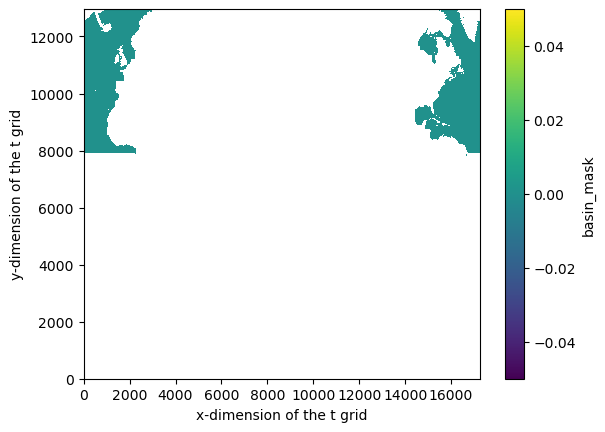

In [30]:
mask.where(mask==0).plot()

In [13]:
delta_rho = 0.1
rho_bins = np.arange(1015, 1035, delta_rho)
avg_mld = 50 #m
weights = coords.rA*avg_mld

In [18]:
rho0 = ds.SSD.isel(time=slice(None, None, 24))

In [19]:
rho0

<xarray.DataArray 'SSD' (time: 377, j: 12960, i: 17280)>
dask.array<getitem, shape=(377, 12960, 17280), dtype=float64, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-23

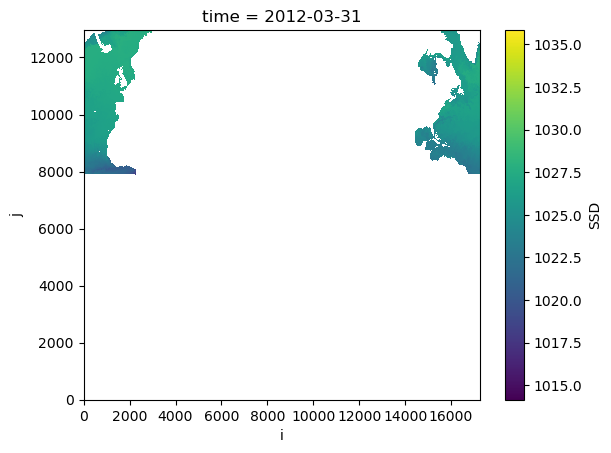

In [35]:
rho0.isel(time=200).where(mask==0).plot()

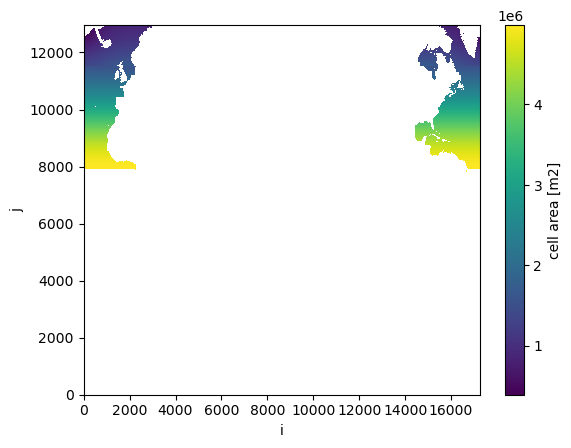

In [37]:
coords.rA.where(mask==0).plot()

In [20]:
from xhistogram.xarray import histogram
def hist_func(ds_basin, variable, basin_index):
    
#    masking = mask==basin_index
    
    hist = (histogram(rho0.where(mask==basin_index).rename('rho0'), 
                      bins=[rho_bins],
                      weights=(ds_basin[variable].fillna(0.)*weights.where(mask==basin_index).fillna(0.)),
                      dim=['i', 'j'],
                      block_size=None) / delta_rho)
    return hist

In [44]:
natl_hist = xr.merge([hist_func(natl_ocean, var, 
                                north_atlantic_ocean).rename('OMEGA_' + var) for var in list(natl_ocean.data_vars)])

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
Task exception was never retrieved
future: <Task finished name='Task-21373' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distri

In [26]:
npac_hist = xr.merge([hist_func(npac_ocean, var, 
                                north_pacific_ocean).rename('OMEGA_' + var) for var in list(npac_ocean.data_vars)])

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv

In [34]:
arc_hist = xr.merge([hist_func(arc_ocean, var, arctic_ocean).rename('OMEGA_' + var) for var in list(arc_ocean.data_vars)])

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv

In [35]:
south_hist = xr.merge([hist_func(south_ocean, var, 
                                 southern_ocean).rename('OMEGA_' + var) for var in list(south_ocean.data_vars)])

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv

In [36]:
ind_hist = xr.merge([hist_func(ind_ocean, var, indian_ocean).rename('OMEGA_' + var) for var in list(ind_ocean.data_vars)])

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 377
  result = blockwise(
/srv

In [37]:
ind_hist

<xarray.Dataset>
Dimensions:              (time: 377, rho0_bin: 199)
Coordinates:
  * time                 (time) datetime64[ns] 2011-09-13 ... 2012-09-23
  * rho0_bin             (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.035e+03
Data variables:
    OMEGA_IND_cabbeling  (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_IND_rho_lap    (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_IND_sss        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_IND_sst        (time, rho0_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

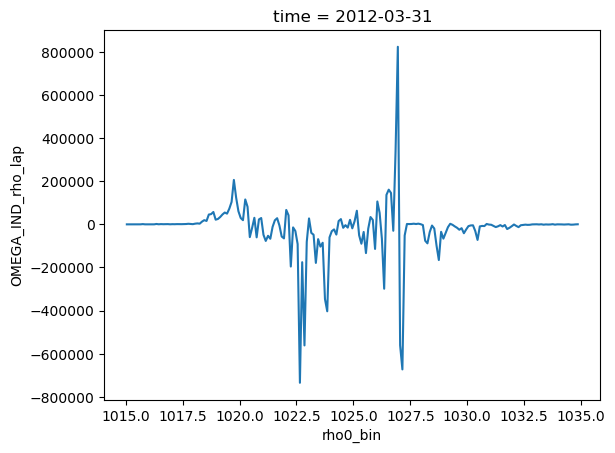

In [38]:
ind_hist.OMEGA_IND_rho_lap.isel(time=200).plot()

In [39]:
res_hist = (ind_hist.OMEGA_IND_rho_lap + ind_hist.OMEGA_IND_cabbeling - 
            ind_hist.OMEGA_IND_sss - ind_hist.OMEGA_IND_sst)

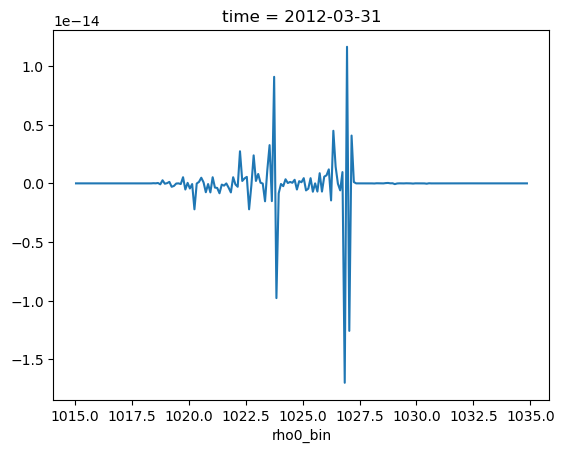

In [40]:
(res_hist/1e6).isel(time=200).plot();

# 5) Save the basin histograms <a class="anchor" id="fourth-bullet"> </a>

In [44]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.1f2bb8cfe3d44ebbbce2ee4e4f35a7cd/status,


In [41]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [42]:
from tqdm import tqdm
import zarr

def to_zarr_split(ds, mapper, split_dim="time", split_interval=1):
    print(f"Writing to {mapper.root} ...")

    n = len(ds[split_dim])
    splits = list(range(0, n, split_interval))

    # Make sure the last item in the list covers the full length
    # of the time on our dataset
    if splits[-1] != n:
        splits = splits + [n]

    split_datasets = []
    for ii in range(len(splits) - 1):
        start = splits[ii]
        stop = splits[ii + 1]
        split_datasets.append(ds.isel({split_dim: slice(start, stop)}))

    # write the first array
    # TODO: move the first write to the loop so it is counted in the viz bar
    split_datasets[0].to_zarr(mapper)
    for ds_split in tqdm(split_datasets[1:None]):
        ds_split.to_zarr(mapper, append_dim=split_dim)

    # overwrite the split dimension as single chunk (this should reproduce
    # what xr.to_zarr would do
    g = zarr.open_group(mapper)
    del g[split_dim]
    
    ds[[split_dim]].load().to_zarr(mapper, mode='a')
    zarr.consolidate_metadata(mapper)

In [45]:
hist_names = ['natl_hist','npac_hist','arc_hist','south_hist','ind_hist']
hist_ds = [natl_hist, npac_hist, arc_hist, south_hist, ind_hist]

for (i,j) in zip(hist_names[1:], hist_ds[1:]):
    mapper = gcfs_w_token.get_mapper(f'pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/' + i + '.zarr')
    to_zarr_split(j, mapper)

Writing to pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/npac_hist.zarr ...


100%|██████████| 376/376 [6:50:16<00:00, 65.47s/it]  


Writing to pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/arc_hist.zarr ...


100%|██████████| 376/376 [6:57:37<00:00, 66.64s/it]  


Writing to pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/south_hist.zarr ...


100%|██████████| 376/376 [6:40:48<00:00, 63.96s/it]t]


Writing to pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/ind_hist.zarr ...


100%|██████████| 376/376 [6:47:58<00:00, 65.10s/it]  


In [47]:
test = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/LLC4320/datasets/basins/basin-histograms/ind_hist.zarr'))

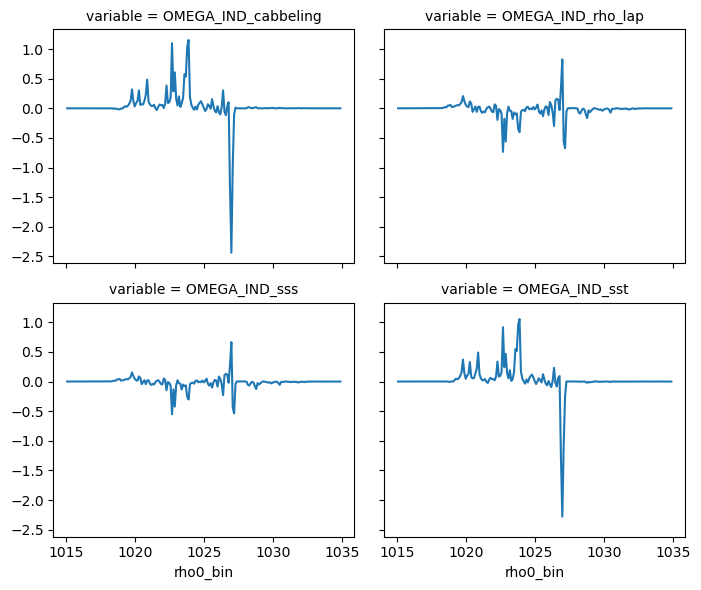

In [52]:
(test.isel(time=200)/1e6).to_array().plot(col='variable', col_wrap=2)

In [55]:
cluster.close()
client.close()